In [41]:
# !pip install --upgrade tqdm
# !pip install seaborn
# !pip install --upgrade jupyter ipywidgets
# %pip install opencv-python
# !pip install opencv-contrib-python
# !nvidia-smi

Requirement already up-to-date: tqdm in /opt/conda/lib/python3.8/site-packages (4.65.0)
Requirement already up-to-date: jupyter in /opt/conda/lib/python3.8/site-packages (1.0.0)
Requirement already up-to-date: ipywidgets in /opt/conda/lib/python3.8/site-packages (8.0.6)
Note: you may need to restart the kernel to use updated packages.
Tue Apr 11 10:17:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:00:05.0 Off |               

In [42]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [43]:
class cfg:
    data_dir = '/opt/ml/input/data/train'
    img_dir = f'{data_dir}/images'
    df_path = f'{data_dir}/train.csv'

In [44]:
num2class = ['incorrect_mask','mask1','mask2','mask3','mask4','mask5','normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.sample(5)

,id,gender,race,age,path
2559,006580,female,Asian,20,006580_female_Asian_20
1976,005020,female,Asian,29,005020_female_Asian_29
2340,006212,male,Asian,19,006212_male_Asian_19
47,000073,female,Asian,52,000073_female_Asian_52
1883,004385,male,Asian,60,004385_male_Asian_60


In [45]:
def get_ext(img_dir, img_id):
    """
    학습 데이터셋 이미지 폴더에는 여러 하위폴더로 구성되고, 이 하위폴더들에는 각 사람의 사진들이 들어가있습니다. 하위폴더에 속한 이미지의 확장자를 구하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름

    Returns:
        ext: 이미지의 확장자
    """
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [46]:
def get_img_stats(img_dir, img_ids):
    """
    데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_ids: 학습 데이터셋 하위폴더 이름들

    Returns:
        img_info: 이미지들의 정보 (크기, 평균, 표준편차)
    """
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [47]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')
print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800916 0.51224077 0.47767341]
RGB Standard Deviation: [0.21817792 0.23804603 0.25183411]


### Y에 대한 분석 (Sex,Age,Mask)

#### 성별 분석

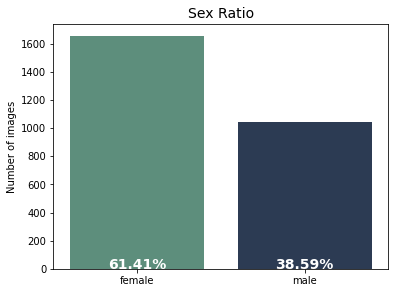

In [48]:
plt.figure(figsize=(6, 4.5)) 
ax = sns.countplot(x = 'gender', data = df, palette=["#55967e", "#263959"])

plt.xticks( np.arange(2), ['female', 'male'] )
plt.title('Sex Ratio',fontsize= 14)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df['gender'].value_counts()
counts_pct = [f'{elem * 100:.2f}%' for elem in counts / counts.sum()]
for i, v in enumerate(counts_pct):
    ax.text(i, 0, v, horizontalalignment = 'center', size = 14, color = 'w', fontweight = 'bold')
    
plt.show()


- 여성에 대한 이미지가 상대적으로 부족합니다.

#### 나이대 분석

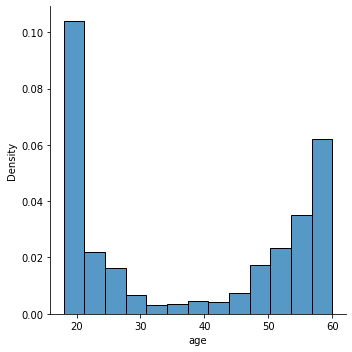

In [49]:
sns.displot(df, x="age", stat="density")
plt.show()

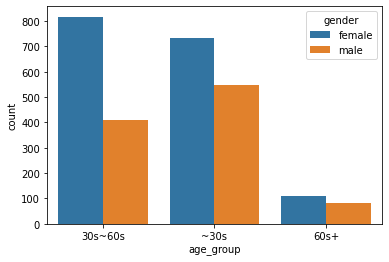

In [73]:

def age_group(age):
    if age < 30:
        return '~30s'
    elif age < 60:
        return '30s~60s'
    else:
        return '60s+'
df['age_group'] = df['age'].apply(age_group)
sns.countplot(df, x="age_group", hue="gender",dodge=True)
plt.show()


- 위 그래프를 보면 60s이상의 데이터가 많이 부족해보입니다.
- 위에서도 언급했듯이 전체적으로 여성의 데이터가 부족합니다. (60대는 어느정도 남녀비율이 비슷)

In [74]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

- max가 60인걸로 보아 60대 이상은 전부 60세로 기록한것 같습니다. -> 회귀로 갔을때 문제가 생길수도 있을거같아요!

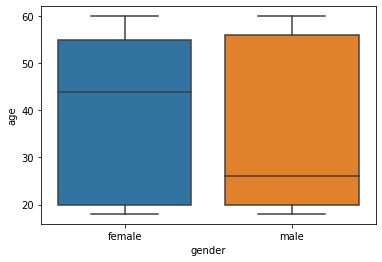

In [75]:
sns.boxplot(x='gender', y='age', data=df)
plt.show()

- 남자보다 여자의 평균나이가 더 적습니다

### 이미지 RGB 통계값과 y특성의 관계
- 이미지 RGB 통계값은 마스크 착용여부를 가리는데 중요한 역할을 합니다.
- 마스크를 쓰면 특정 RGB 값에 집중될 수 있습니다. (흰 마스크를 쓰게 되면 RGB 통계값이 높음)
- 따라서 아래서 볼 클래스마다의 그래프들이 뚜렷히 구분 될 수록 모델은 쉽게 학습 할 수 있습니다.  
- 현재는 배경 이미지의 데이터가 많이 섞여있기때문에 아래서 볼 그래프들은 비슷한 경향성을 띄고 있습니다.
- 배경이미지를 전처리 해준후 시각화를 한번 더 진행해봐도 좋을것같습니다.

In [76]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir, img_id)

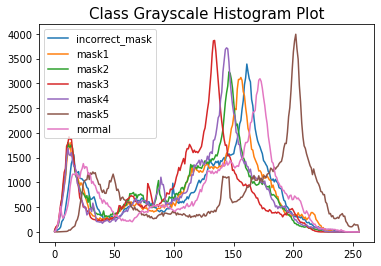

In [79]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

- 위그래프에서 X축이 RGB 통계값이고 Y축이 픽셀의 빈도수라고 생각하면 될것같습니다.
- 그래서 하나의 클래스에 어떤색의 픽셀이 많은지 판단하는 데이터 시각화입니다.
- 예를들어 mask5는 아마 핑크색마스크여서 다른 클래스보다 구분이 잘되는것 같습니다. 

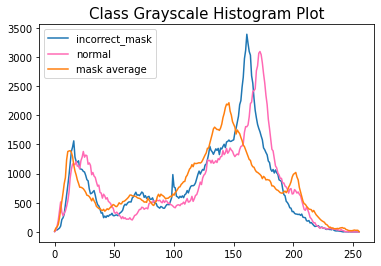

In [80]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'incorrect_mask'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)).convert('L'))
histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
sns.lineplot(data=histogram, color='hotpink')

histograms = []
for i in range(1, 6):
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, num2class[i]+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    histograms.append(histogram)
sns.lineplot(data=np.mean(histograms, axis=0))

plt.legend(['incorrect_mask', 'normal', 'mask average'])
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

- 위 그래프가 구분이 잘될수록 모델도 구분을 잘할것 같습니다.

No handles with labels found to put in legend.


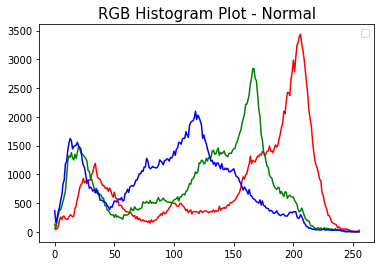

In [59]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'normal'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - Normal', fontsize=15)
plt.show()

No handles with labels found to put in legend.


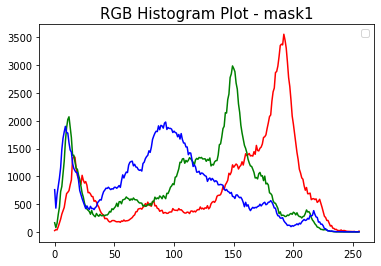

In [60]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, 'mask1'+ext)))
colormap = ['red', 'green', 'blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[..., i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram, color=colormap[i])

plt.legend()
plt.title('RGB Histogram Plot - mask1', fontsize=15)
plt.show()

- Normal과 별다른 차이가 없어보이지안 0에 근접한곳에서 빈도수가 더 높습니다.

In [61]:
def plot_raw_images(img_dir, img_id):
    """
    마스크 미착용 이미지를 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    img = np.array(Image.open(os.path.join(img_dir, img_id, 'normal' + ext)))
    
    plt.figure(figsize=(6,6))
    plt.imshow(img)

In [62]:
def show_from_id(idx):
    img_id = df.iloc[idx].path
    gen = df.iloc[idx].gender
    age = df.iloc[idx].age
    plot_raw_images(cfg.img_dir, img_id)
    plt.title(f'{gen} {age}')
    plt.show()


- 남성인거같은데 여성으로 되어있는데이터

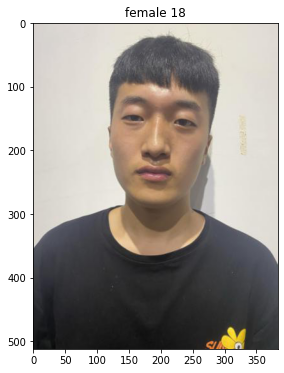

In [86]:
show_from_id(2399)

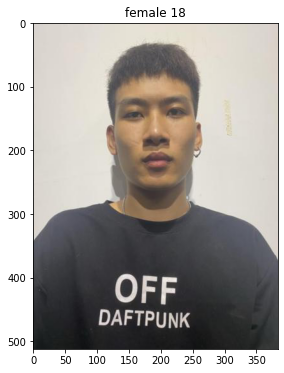

In [64]:
show_from_id(2400)

In [65]:
def plot_mask_images(img_dir, img_id):
    """
    마스크 정상착용 5장과 이상하게 착용한 1장을 2x3의 격자에 시각화하는 함수입니다.
    
    Args:
        img_dir: 학습 데이터셋 이미지 폴더 경로 
        img_id: 학습 데이터셋 하위폴더 이름
    """
    ext = get_ext(img_dir, img_id)
    imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]
    
    n_rows, n_cols = 2, 3
    fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15, 12))
    for i in range(n_rows*n_cols):
        axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
        axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}', color='r')
    plt.tight_layout()
    plt.show()

- 마지막은 normal 클래스를 제외한 마스크착용사진입니다.

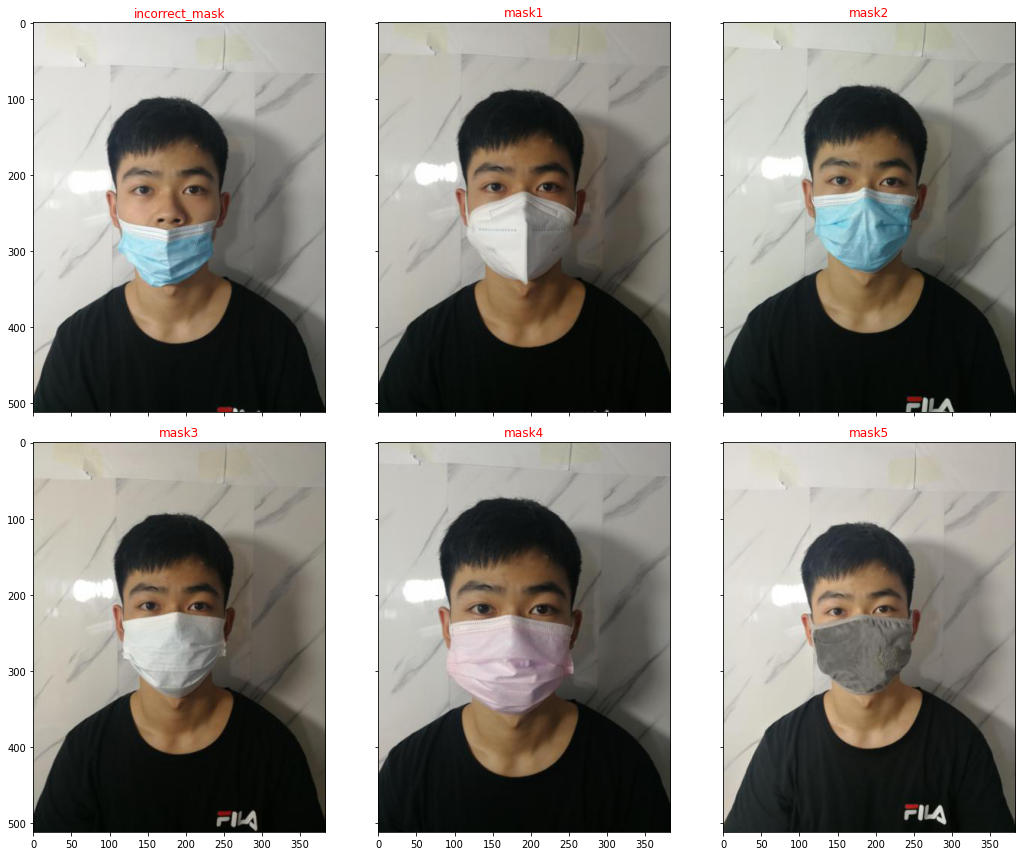

In [101]:
idx = 499
img_id = df.iloc[idx].path
plot_mask_images(cfg.img_dir, img_id)